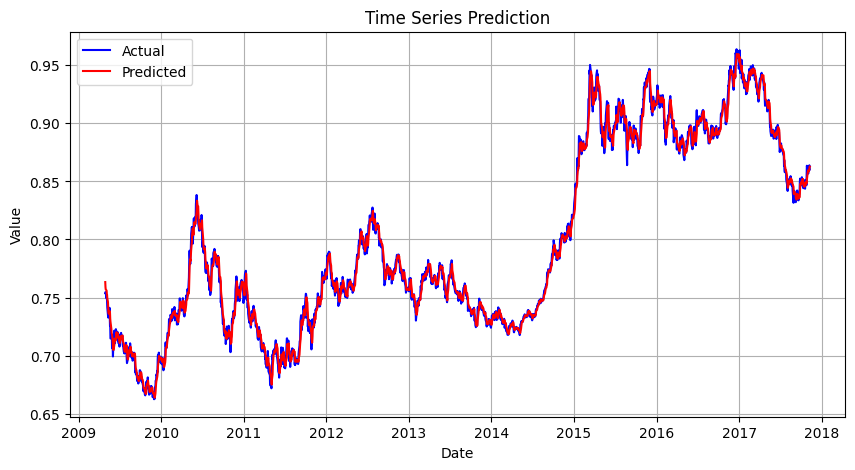

(3.2524705226051726e-05,
 0.005703043505537349,
 0.004345217651385818,
 0.9949502308542031)

In [6]:
# Re-import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("BOE-XUDLERD.csv")

# Convert date to datetime and sort in ascending order
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

# Extract values
values = df["Value"].values.reshape(-1, 1)

# Split data into train (80%) and test (20%)
train_size = int(len(values) * 0.8)
train_values, test_values = values[:train_size], values[train_size:]

# Normalize data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# Create sequences for time series forecasting
seq_len = 10

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Prepare sequences
X_train, y_train = create_sequences(train_scaled, seq_len)
X_test, y_test = create_sequences(test_scaled, seq_len)

# Flatten input sequences for linear regression model
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train a Ridge regression model
model = Ridge(alpha=1.0)
model.fit(X_train_flat, y_train.ravel())

# Predict on the test set
y_pred = model.predict(X_test_flat)

# Inverse transform predictions and true values to original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Calculate error metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(df["Date"].iloc[train_size + seq_len:], y_test_inv, label="Actual", color="blue")
plt.plot(df["Date"].iloc[train_size + seq_len:], y_pred_inv, label="Predicted", color="red")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series Prediction")
plt.legend()
plt.grid()
plt.show()

# Display error metrics
mse, rmse, mae, r2


Epoch 1/20, Loss: 0.000047
Epoch 2/20, Loss: 0.000039
Epoch 3/20, Loss: 0.000039
Epoch 4/20, Loss: 0.000039
Epoch 5/20, Loss: 0.000039
Epoch 6/20, Loss: 0.000040
Epoch 7/20, Loss: 0.000038
Epoch 8/20, Loss: 0.000039
Epoch 9/20, Loss: 0.000038
Epoch 10/20, Loss: 0.000039
Epoch 11/20, Loss: 0.000039
Epoch 12/20, Loss: 0.000039
Epoch 13/20, Loss: 0.000039
Epoch 14/20, Loss: 0.000039
Epoch 15/20, Loss: 0.000038
Epoch 16/20, Loss: 0.000039
Epoch 17/20, Loss: 0.000039
Epoch 18/20, Loss: 0.000039
Epoch 19/20, Loss: 0.000039
Epoch 20/20, Loss: 0.000039
MSE: 0.000024, RMSE: 0.004860, MAE: 0.003613, R2: 0.996333


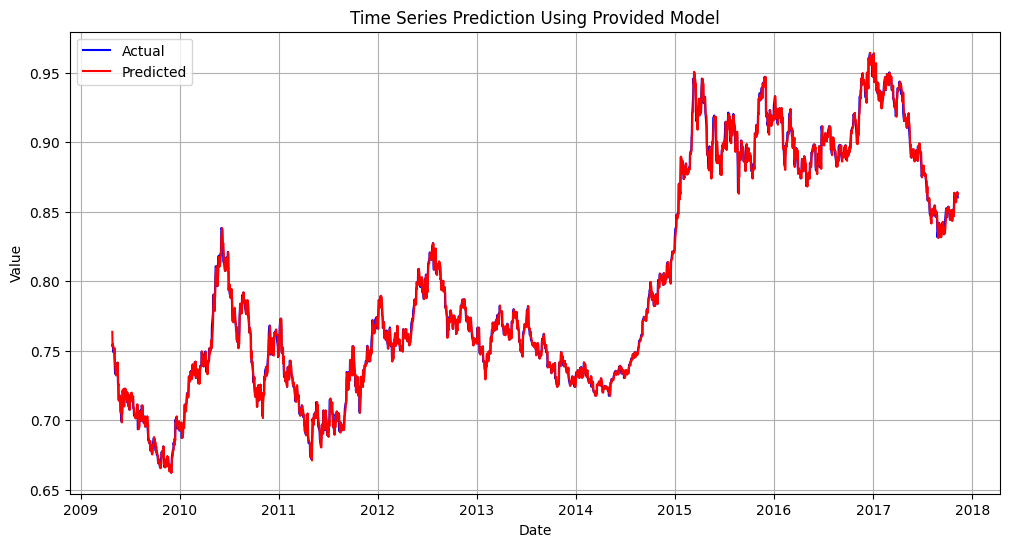

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ---------------------------
# Define RevIN (Reversible Instance Normalization)
# ---------------------------
class RevIN(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(RevIN, self).__init__()
        self.eps = eps
        # These buffers will store mean and std for denormalization
        self.register_buffer("mean", torch.zeros(1))
        self.register_buffer("std", torch.ones(1))

    def forward(self, x, mode):
        # x shape: [B, L, D] where D == num_features
        if mode == 'norm':
            # Compute per-instance, per-channel statistics along the time dimension (L)
            self.mean = x.mean(dim=1, keepdim=True)
            self.std = x.std(dim=1, keepdim=True) + self.eps
            return (x - self.mean) / self.std
        elif mode == 'denorm':
            return x * self.std + self.mean
        else:
            raise ValueError("mode should be 'norm' or 'denorm'")

# ---------------------------
# Define your provided Model
# ---------------------------
class Model(nn.Module):
    def __init__(self, channel, d_model, seq_len, pred_len):
        super(Model, self).__init__()
        # Temporal mixing: a simple extractor (e.g., MLP applied along the sequence length)
        self.temporal = nn.Sequential(
            nn.Linear(seq_len, d_model),
            nn.GELU(),
            nn.Linear(d_model, seq_len)
        )
        # Channel mixing: another extractor (e.g., MLP applied across channels)
        self.channel = nn.Sequential(
            nn.Linear(channel, d_model),
            nn.GELU(),
            nn.Linear(d_model, channel)
        )
        # Final projection layer to predict future value(s)
        self.projection = nn.Linear(seq_len, pred_len)
        # RevIN layer for normalization and denormalization
        self.rev = RevIN(channel)
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    # Loss function: Mean Squared Error
    def forward_loss(self, pred, true):
        return F.mse_loss(pred, true)

    def forward(self, x, y):
        # x: [B, L, D], where D = channel
        # Normalize the input
        x = self.rev(x, 'norm')
        # Apply temporal mixing. We first transpose to shape [B, D, L], apply the temporal MLP, then transpose back.
        x = x + self.temporal(x.transpose(1, 2)).transpose(1, 2)
        # Apply channel mixing
        x = x + self.channel(x)
        # Project to the prediction length: transpose to shape [B, D, L] so that the projection layer works on the time dimension,
        # then transpose back.
        pred = self.projection(x.transpose(1, 2)).transpose(1, 2)
        # Denormalize the prediction to return to the original scale
        pred = self.rev(pred, 'denorm')
        return pred, self.forward_loss(pred, y)

# ---------------------------
# PyTorch Dataset for Time Series
# ---------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences  # shape: [N, seq_len, num_features]
        self.targets = targets      # shape: [N, pred_len]
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# ---------------------------
# Data Preprocessing
# ---------------------------
# Load the CSV file
file_path = "BOE-XUDLERD.csv"
df = pd.read_csv(file_path)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

# Extract the 'Value' column (we have one feature)
values = df["Value"].values.reshape(-1, 1)

# Split data: 80% train, 20% test
train_size = int(len(values) * 0.8)
train_values = values[:train_size]
test_values = values[train_size:]

# Normalize the data (fit on train, transform both)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# Sequence parameters
seq_len = 10   # input sequence length
pred_len = 1   # predict one time step ahead
channel = 1    # number of features (channels)

def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len + 1):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+pred_len])
    return np.array(X), np.array(y)

# Create sequences for training and testing
X_train_np, y_train_np = create_sequences(train_scaled, seq_len, pred_len)
X_test_np, y_test_np = create_sequences(test_scaled, seq_len, pred_len)

# Convert to torch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# Initialize and Train the Model
# ---------------------------
# Hyperparameters for the model
d_model = 64  # dimension of the hidden layers in the mixing modules

device = torch.device("cpu")  # use CPU; change to "cuda" if available and working

model = Model(channel=channel, d_model=d_model, seq_len=seq_len, pred_len=pred_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        pred, loss = model(batch_x, batch_y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(epoch_losses):.6f}")

# ---------------------------
# Evaluate the Model on Test Set
# ---------------------------
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred, loss = model(batch_x, batch_y)
        predictions.append(pred.cpu().numpy())
        actuals.append(batch_y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)  # shape: [N, pred_len, 1]
actuals = np.concatenate(actuals, axis=0)          # shape: [N, pred_len, 1]

# Inverse transform to original scale
predictions_inv = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(-1)
actuals_inv = scaler.inverse_transform(actuals.reshape(-1, 1)).reshape(-1)

# Calculate error metrics
mse = mean_squared_error(actuals_inv, predictions_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals_inv, predictions_inv)
r2 = r2_score(actuals_inv, predictions_inv)
print(f"MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, R2: {r2:.6f}")

# ---------------------------
# Plot Actual vs. Predicted Values
# ---------------------------
# Get corresponding dates for the test predictions.
# The first test sequence corresponds to index (train_size) in the test set,
# but since we created sequences with a window of seq_len, the prediction date corresponds to:
dates = df["Date"].iloc[train_size + seq_len - 1 : train_size + seq_len - 1 + len(predictions_inv)]

plt.figure(figsize=(12, 6))
plt.plot(dates, actuals_inv, label="Actual", color="blue")
plt.plot(dates, predictions_inv, label="Predicted", color="red")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series Prediction Using Provided Model")
plt.legend()
plt.grid(True)
plt.show()
